In [1]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans


%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\Админ\Desktop\data.csv', encoding="ISO-8859-1")


In [3]:
initial_dataset=df

In [4]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Data preprocessing

### data type conversion

In [6]:
df['InvoiceNo'] = df['InvoiceNo'].astype('category') 
df['StockCode'] = df['StockCode'].astype('category') 
df['Description'] = df['Description'].astype('category')  
df['Quantity'] = df['Quantity'].astype('int16')  
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')  # Convert to datetime
df['UnitPrice'] = df['UnitPrice'].astype('float32')  # Use a smaller float type
df['CustomerID'] = df['CustomerID'].astype('Int64')  # rs
df['Country'] = df['Country'].astype('category')  # Use category for non-numeric identifiers

print(df.dtypes)

InvoiceNo            category
StockCode            category
Description          category
Quantity                int16
InvoiceDate    datetime64[ns]
UnitPrice             float32
CustomerID              Int64
Country              category
dtype: object


In [7]:
# Summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,64.654892,-15459.00000,1.00,3.00,10.00,15459.0
UnitPrice,541909.0,4.611114,96.759857,-11062.05957,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00000,13953.00,15152.00,16791.00,18287.0


### missing values

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
missing_counts = df.isnull().sum()
missing_counts

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:

missing_percentages = (missing_counts[missing_counts > 0] / len(df)) * 100
missing_percentages.sort_values(ascending=True, inplace=True)
missing_percentages

Description     0.268311
CustomerID     24.926694
dtype: float64

In [10]:
df[df['CustomerID'].isnull()].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,<NA>,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,<NA>,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,<NA>,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,<NA>,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,<NA>,United Kingdom


In [11]:
df[df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,<NA>,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,<NA>,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,<NA>,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,<NA>,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,<NA>,United Kingdom


In [12]:

df = df.dropna(subset=['CustomerID', 'Description'])

### duplicate values


In [13]:

duplicate_rows = df[df.duplicated(keep=False)]

duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])


duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920,United Kingdom


In [14]:
# How many duplicate rows are there?

df.duplicated().sum()

5225

In [15]:
df.drop_duplicates(inplace=True)

# rows with non-numeric stock codes

In [16]:

unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
dtype: int64


In [17]:
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [18]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

### Service related descriptions

In [19]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]
df = df[~df['Description'].isin(service_related_descriptions)]
df['Description'] = df['Description'].str.upper()

In [20]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


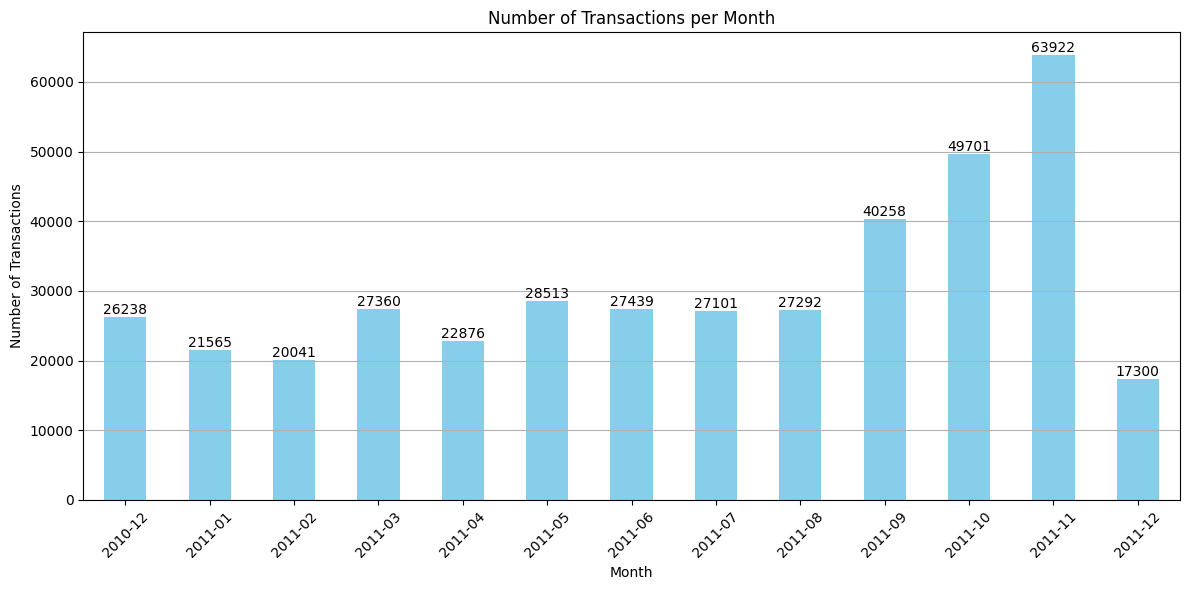

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'InvoiceDate' is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Group by month and count the number of transactions (InvoiceNo)
transactions_per_month = df.groupby(df['InvoiceDate'].dt.to_period('M'))['InvoiceNo'].count()

# Plotting the number of transactions per month
plt.figure(figsize=(12, 6))
bars = transactions_per_month.plot(kind='bar', color='skyblue')
plt.title('Number of Transactions per Month')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid lines only on the y-axis

# Adding values on top of the bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
             int(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


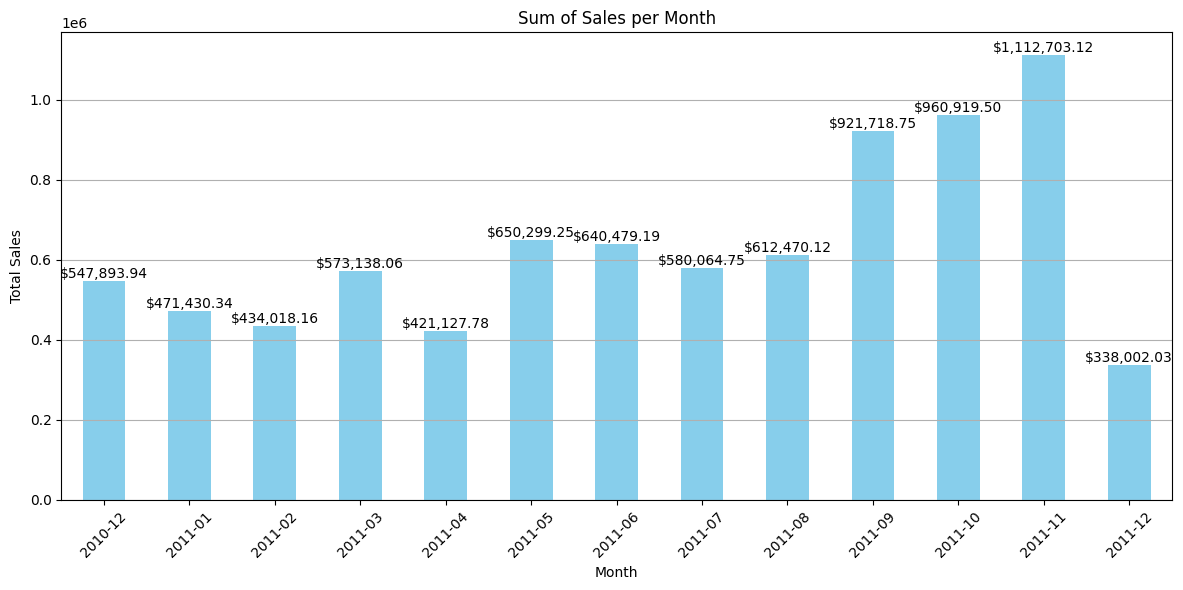

In [22]:
# Calculate total sales
df['Total_Sales'] = df['Quantity'] * df['UnitPrice']

# Group by month and sum the total sales
sales_per_month = df.groupby(df['InvoiceDate'].dt.to_period('M'))['Total_Sales'].sum()

# Plotting the sum of sales per month
plt.figure(figsize=(12, 6))
bars = sales_per_month.plot(kind='bar', color='skyblue')
plt.title('Sum of Sales per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid lines only on the y-axis

# Adding values on top of the bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
             f'${bar.get_height():,.2f}', ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

In [23]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.299999
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.340000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.000000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.340000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.340000
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.200001
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.599999
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.600000
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.600000


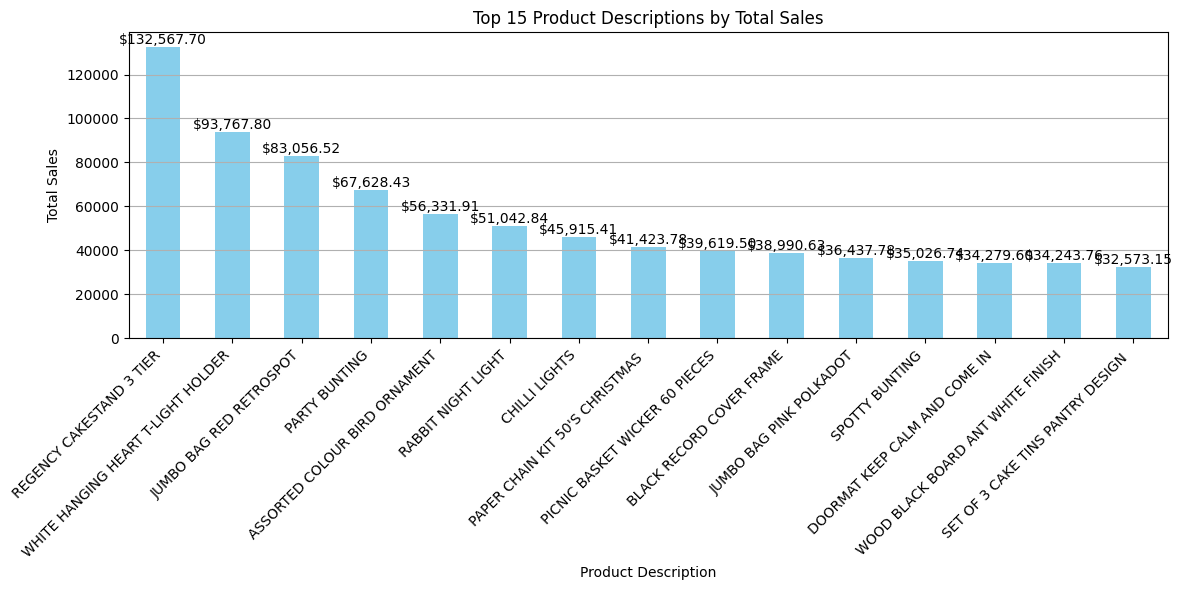

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Calculate total sales
df['Total_Sales'] = df['Quantity'] * df['UnitPrice']

# Group by description and sum total sales
total_sales_by_description = df.groupby('Description')['Total_Sales'].sum()

# Get the top 15 descriptions by total sales
top_15_sales = total_sales_by_description.nlargest(15)

# Plotting the top 15 product descriptions by total sales
plt.figure(figsize=(12, 6))
bars = top_15_sales.plot(kind='bar', color='skyblue')
plt.title('Top 15 Product Descriptions by Total Sales')
plt.xlabel('Product Description')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid lines only on the y-axis

# Adding values on top of the bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
             f'${bar.get_height():,.2f}', ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


In [25]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.299999
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.340000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.000000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.340000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.340000
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.200001
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.599999
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.600000
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.600000


In [26]:
# Get unique values from the Quantity column
unique_quantities = df['Quantity'].unique()

# Convert to list
unique_quantities_list = unique_quantities.tolist()

# Separate into positive and negative values
positive_values = [value for value in unique_quantities_list if value > 0]
negative_values = [value for value in unique_quantities_list if value < 0]
positive_values.sort(reverse=True)
negative_values.sort()

print("Sorted unique positive values in the 'Quantity' column (descending):", positive_values)
print("Sorted unique negative values in the 'Quantity' column (ascending):", negative_values)

Sorted unique positive values in the 'Quantity' column (descending): [15459, 12540, 8679, 4800, 4300, 3906, 3186, 3114, 3000, 2880, 2700, 2592, 2400, 2160, 2100, 2040, 2000, 1992, 1944, 1930, 1900, 1878, 1824, 1788, 1728, 1600, 1540, 1515, 1500, 1488, 1440, 1428, 1412, 1404, 1400, 1394, 1356, 1350, 1300, 1296, 1284, 1200, 1152, 1120, 1056, 1020, 1010, 1008, 1000, 992, 972, 968, 960, 912, 906, 900, 888, 864, 860, 852, 840, 828, 824, 800, 774, 768, 760, 756, 744, 738, 720, 708, 701, 700, 698, 696, 684, 672, 670, 666, 660, 648, 640, 630, 624, 620, 612, 608, 600, 588, 576, 560, 552, 540, 528, 512, 504, 500, 496, 494, 492, 490, 480, 468, 462, 456, 450, 448, 432, 430, 428, 420, 416, 410, 408, 407, 402, 400, 396, 392, 388, 384, 378, 360, 352, 350, 348, 342, 336, 330, 324, 323, 320, 312, 306, 304, 300, 291, 288, 280, 276, 273, 272, 270, 264, 261, 256, 255, 252, 250, 248, 246, 244, 240, 236, 234, 232, 230, 228, 227, 224, 222, 220, 216, 210, 208, 204, 200, 198, 196, 192, 188, 186, 180, 176, 168,

### treating cancelled transactions

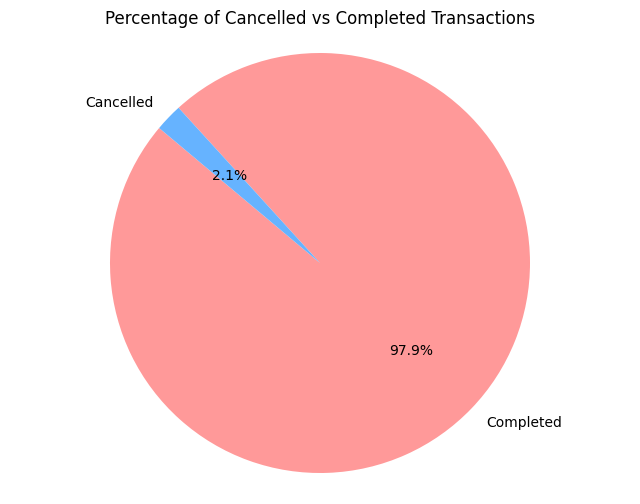

In [27]:
# Assuming df is your DataFrame and Transaction_Status is already created
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Count the number of each transaction status
transaction_counts = df['Transaction_Status'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(transaction_counts, labels=transaction_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Percentage of Cancelled vs Completed Transactions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [28]:
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice,Total_Sales
count,8505.000000,8505.000000,8505.000000
mean,-16.065608,4.438907,-31.424265
std,227.354202,9.198968,390.451416
min,-15459.000000,0.030000,-32154.718750
25%,-6.000000,1.450000,-16.600000
50%,-2.000000,2.550000,-8.300000
75%,-1.000000,4.950000,-3.300000
max,-1.000000,295.000000,-0.120000


In [29]:
# RFM -method used for segmenting the customer base
# r recency
# f frequency
# m montery

# EDA

## Recency

In [30]:

df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

customer_data

,CustomerID,InvoiceDay
0,12346,2011-01-18
1,12347,2011-12-07
2,12348,2011-09-25
3,12349,2011-11-21
4,12350,2011-02-02
...,...,...
4358,18280,2011-03-07
4359,18281,2011-06-12
4360,18282,2011-12-02
4361,18283,2011-12-06


In [31]:
# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()
most_recent_date

datetime.date(2011, 12, 9)

In [32]:
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)
most_recent_date

Timestamp('2011-12-09 00:00:00')

In [33]:
#the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [34]:
customer_data

,CustomerID,Days_Since_Last_Purchase
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310
...,...,...
4358,18280,277
4359,18281,180
4360,18282,7
4361,18283,3


## frequency

In [35]:

total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)


total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346,325,2,0
1,12347,2,7,2458
2,12348,75,4,2332
3,12349,18,1,630
4,12350,310,1,196
...,...,...,...,...
4358,18280,277,1,45
4359,18281,180,1,54
4360,18282,7,3,98
4361,18283,3,16,1355


## monetary

In [36]:
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()


average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346,325,2,0,0.000000,0.000000
1,12347,2,7,2458,4310.000000,615.714286
2,12348,75,4,2332,1437.239990,359.309998
3,12349,18,1,630,1457.550049,1457.550049
4,12350,310,1,196,294.399994,294.399994
...,...,...,...,...,...,...
4358,18280,277,1,45,180.600006,180.600006
4359,18281,180,1,54,80.820000,80.820000
4360,18282,7,3,98,176.600006,58.866669
4361,18283,3,16,1355,2039.579956,127.473747


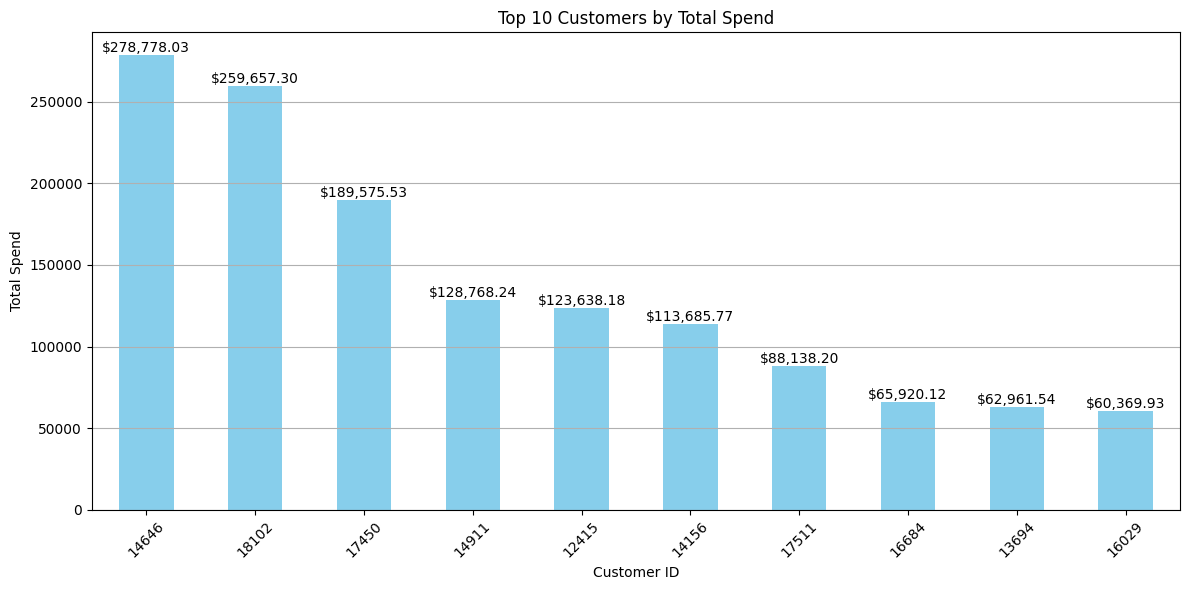

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and has a 'Total_Spend' column
# Group by CustomerID and sum their total spend
top_customers = customer_data.groupby('CustomerID')['Total_Spend'].sum().nlargest(10)

# Plotting
plt.figure(figsize=(12, 6))
bars = top_customers.plot(kind='bar', color='skyblue')
plt.title('Top 10 Customers by Total Spend')
plt.xlabel('Customer ID')
plt.ylabel('Total Spend')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid lines only on the y-axis

# Adding values on top of the bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
             f'${bar.get_height():,.2f}', ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


## Product diversity
### A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products

In [38]:
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')
customer_data

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346,325,2,0,0.000000,0.000000,1
1,12347,2,7,2458,4310.000000,615.714286,103
2,12348,75,4,2332,1437.239990,359.309998,21
3,12349,18,1,630,1457.550049,1457.550049,72
4,12350,310,1,196,294.399994,294.399994,16
...,...,...,...,...,...,...,...
4358,18280,277,1,45,180.600006,180.600006,10
4359,18281,180,1,54,80.820000,80.820000,7
4360,18282,7,3,98,176.600006,58.866669,12
4361,18283,3,16,1355,2039.579956,127.473747,262


In [39]:
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour


days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)


favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]


favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]


customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

customer_data

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346,325,2,0,0.000000,0.000000,1,0.000000,1,10
1,12347,2,7,2458,4310.000000,615.714286,103,2.016575,1,14
2,12348,75,4,2332,1437.239990,359.309998,21,10.884615,3,19
3,12349,18,1,630,1457.550049,1457.550049,72,0.000000,0,9
4,12350,310,1,196,294.399994,294.399994,16,0.000000,2,16
...,...,...,...,...,...,...,...,...,...,...
4277,18280,277,1,45,180.600006,180.600006,10,0.000000,0,9
4278,18281,180,1,54,80.820000,80.820000,7,0.000000,6,10
4279,18282,7,3,98,176.600006,58.866669,12,9.916667,4,13
4280,18283,3,16,1355,2039.579956,127.473747,262,0.465181,3,14


In [40]:
### Customer's location

In [41]:
df['Country'].value_counts(normalize=True).head()

United Kingdom    0.890948
Germany           0.022722
France            0.020400
EIRE              0.018443
Spain             0.006164
Name: Country, dtype: float64

In [42]:
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')
customer_main_country

,CustomerID,Country,Number_of_Transactions
153328,17841,United Kingdom,7800
71906,14911,EIRE,5808
49322,14096,United Kingdom,5095
12500,12748,United Kingdom,4440
63534,14606,United Kingdom,2755
...,...,...,...
66346,14705,United Kingdom,1
138470,17307,United Kingdom,1
161612,18141,United Kingdom,1
14048,12814,Poland,1


In [43]:

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)


customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')


customer_data

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346,325,2,0,0.000000,0.000000,1,0.000000,1,10,1
1,12347,2,7,2458,4310.000000,615.714286,103,2.016575,1,14,0
2,12348,75,4,2332,1437.239990,359.309998,21,10.884615,3,19,0
3,12349,18,1,630,1457.550049,1457.550049,72,0.000000,0,9,0
4,12350,310,1,196,294.399994,294.399994,16,0.000000,2,16,0
...,...,...,...,...,...,...,...,...,...,...,...
4277,18280,277,1,45,180.600006,180.600006,10,0.000000,0,9,1
4278,18281,180,1,54,80.820000,80.820000,7,0.000000,6,10,1
4279,18282,7,3,98,176.600006,58.866669,12,9.916667,4,13,1
4280,18283,3,16,1355,2039.579956,127.473747,262,0.465181,3,14,1


In [44]:
# Calculate the mode for Day_Of_Week and Hour
day_of_week_mode = customer_data['Day_Of_Week'].mode()[0]
hour_mode = customer_data['Hour'].mode()[0]

# Count occurrences of the mode
day_of_week_mode_count = customer_data['Day_Of_Week'].value_counts()[day_of_week_mode]
hour_mode_count = customer_data['Hour'].value_counts()[hour_mode]

# Total number of entries
total_entries = len(customer_data)

# Calculate percentages
day_of_week_mode_percentage = (day_of_week_mode_count / total_entries) * 100
hour_mode_percentage = (hour_mode_count / total_entries) * 100

print(f"Mode of Day Of Week: {day_of_week_mode} ({day_of_week_mode_percentage:.2f}%)")
print(f"Mode of Hour: {hour_mode} ({hour_mode_percentage:.2f}%)")


Mode of Day Of Week: 3 (22.35%)
Mode of Hour: 12 (17.45%)


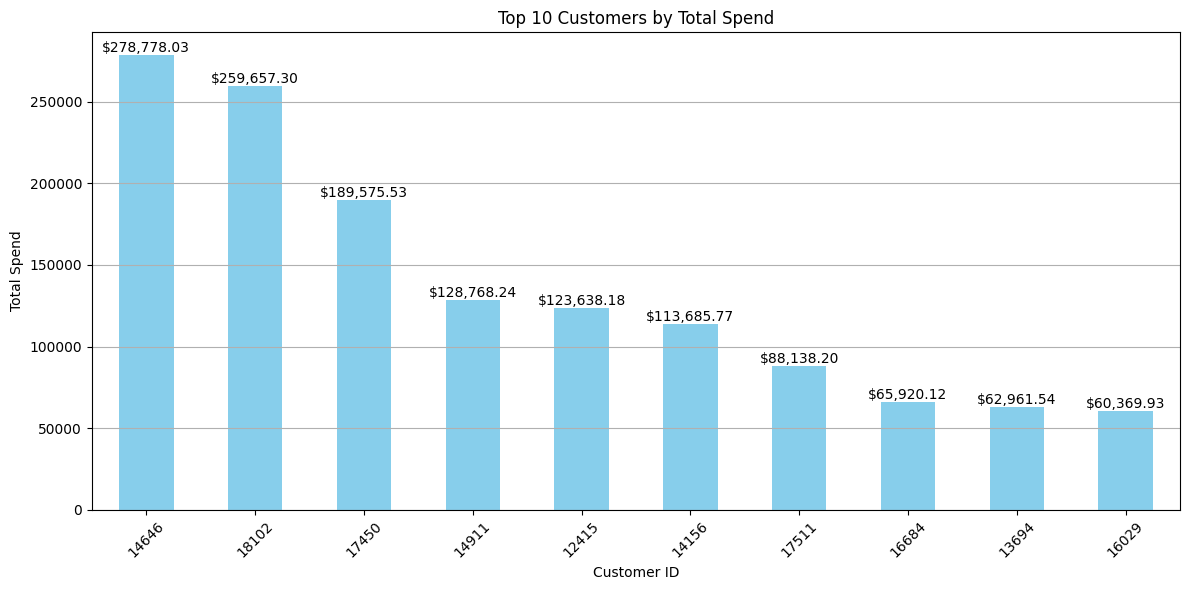

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and has a 'Total_Spend' column
# Group by CustomerID and sum their total spend
top_customers = df.groupby('CustomerID')['Total_Spend'].sum().nlargest(10)

# Plotting
plt.figure(figsize=(12, 6))
bars = top_customers.plot(kind='bar', color='skyblue')
plt.title('Top 10 Customers by Total Spend')
plt.xlabel('Customer ID')
plt.ylabel('Total Spend')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid lines only on the y-axis

# Adding values on top of the bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
             f'${bar.get_height():,.2f}', ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


### seasonal trends


In [45]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month



In [46]:


# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

In [47]:
seasonal_buying_patterns

,CustomerID,Monthly_Spending_Mean,Monthly_Spending_Std
0,12346,0.000000,0.000000
1,12347,615.714294,341.070769
2,12348,359.309998,203.875682
3,12349,1457.550049,0.000000
4,12350,294.399994,0.000000
...,...,...,...
4358,18280,180.600006,0.000000
4359,18281,80.820000,0.000000
4360,18282,88.300003,14.792678
4361,18283,203.958008,165.798745


In [48]:
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')


## Correlation analysis

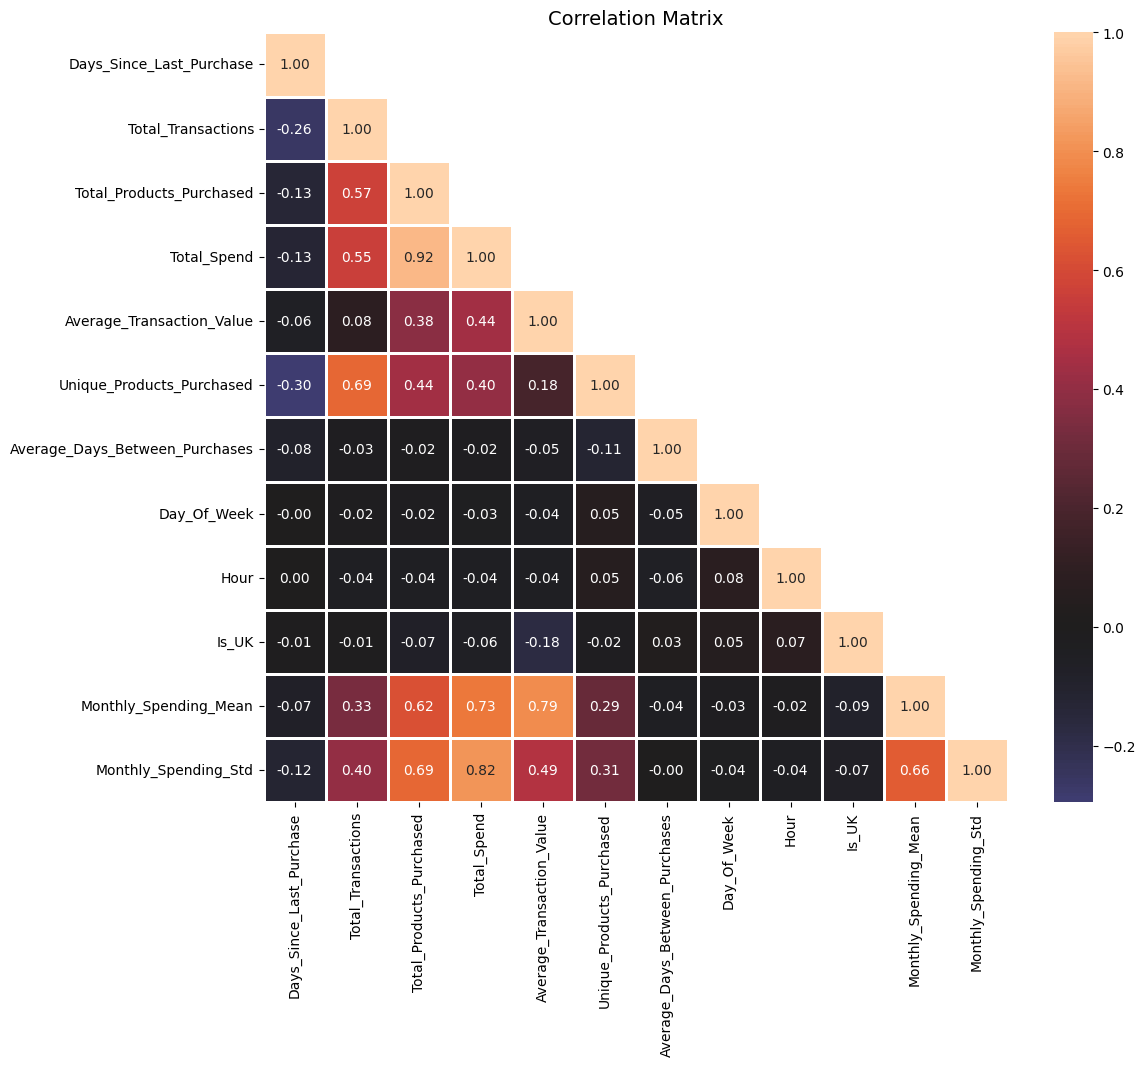

In [49]:

corr = customer_data.drop(columns=['CustomerID']).corr()



# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

### Clusters/Customer segmentation

In [50]:
df=customer_data

In [51]:
df

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std
0,12346,325,2,0,0.000000,0.000000,1,0.000000,1,10,1,0.000000,0.000000
1,12347,2,7,2458,4310.000000,615.714286,103,2.016575,1,14,0,615.714294,341.070769
2,12348,75,4,2332,1437.239990,359.309998,21,10.884615,3,19,0,359.309998,203.875682
3,12349,18,1,630,1457.550049,1457.550049,72,0.000000,0,9,0,1457.550049,0.000000
4,12350,310,1,196,294.399994,294.399994,16,0.000000,2,16,0,294.399994,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,18280,277,1,45,180.600006,180.600006,10,0.000000,0,9,1,180.600006,0.000000
4278,18281,180,1,54,80.820000,80.820000,7,0.000000,6,10,1,80.820000,0.000000
4279,18282,7,3,98,176.600006,58.866669,12,9.916667,4,13,1,88.300003,14.792678
4280,18283,3,16,1355,2039.579956,127.473747,262,0.465181,3,14,1,203.958008,165.798745


In [59]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Drop 'CustomerID' as it's not useful for clustering
X = df.drop(['CustomerID'], axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Set n_jobs to 1
df['Segment'] = kmeans.fit_predict(X_scaled)
df.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std,Segment
0,12346,325,2,0,0.000000,0.000000,1,0.000000,1,10,1,0.000000,0.000000,1
1,12347,2,7,2458,4310.000000,615.714286,103,2.016575,1,14,0,615.714294,341.070769,2
2,12348,75,4,2332,1437.239990,359.309998,21,10.884615,3,19,0,359.309998,203.875682,2
3,12349,18,1,630,1457.550049,1457.550049,72,0.000000,0,9,0,1457.550049,0.000000,2
4,12350,310,1,196,294.399994,294.399994,16,0.000000,2,16,0,294.399994,0.000000,2


In [60]:
segment_summary = df.groupby('Segment').mean()
segment_summary

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Monthly_Spending_Mean,Monthly_Spending_Std
Segment,,,,,,,,,,,,,
0,15565.832222,34.594444,7.341111,1295.065000,2165.199951,316.399555,97.121667,2.357770,3.396111,13.266667,1.000000,453.467224,213.233415
1,15551.443951,138.694815,2.447407,355.781235,577.812012,254.049405,28.032593,4.658848,1.851852,11.905679,1.000000,293.991638,72.756443
2,13068.717724,87.120350,7.730853,3960.940919,6955.515625,649.774145,76.934354,2.284289,2.247265,11.969365,0.089716,1172.496094,622.552236


In [61]:
# Segment 0: High Engagement, Moderate Spend
#Segment 1: Low Engagement, Low Spend
#Segment 2: High Spend, Non-UK Customers

## feature scaling for PCA

In [55]:

X = df.drop(columns=['CustomerID', 'Segment'])  
y = df['Segment']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# PCA

In [56]:
from sklearn.model_selection import train_test_split
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)


X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)


### Decision tree

In [57]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [58]:


print("Decision Tree:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_dt, average='weighted'))
print(classification_report(y_test, y_pred_dt))


Decision Tree:


NameError: name 'accuracy_score' is not defined

# Advanced Classification Methods


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.neural_network import MLPClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Support Vector Machine
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Neural Network
nn = MLPClassifier(random_state=42, max_iter=500)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)


print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
print(classification_report(y_test, y_pred_rf))


print("Support Vector Machine:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm, average='weighted'))
print(classification_report(y_test, y_pred_svm))


print("Neural Network:")
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Precision:", precision_score(y_test, y_pred_nn, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nn, average='weighted'))
print(classification_report(y_test, y_pred_nn))


In [64]:
customer_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4282 entries, 0 to 4281
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   Int64  
 1   Days_Since_Last_Purchase        4282 non-null   int64  
 2   Total_Transactions              4282 non-null   int64  
 3   Total_Products_Purchased        4282 non-null   int64  
 4   Total_Spend                     4282 non-null   float32
 5   Average_Transaction_Value       4282 non-null   float64
 6   Unique_Products_Purchased       4282 non-null   int64  
 7   Average_Days_Between_Purchases  4282 non-null   float64
 8   Day_Of_Week                     4282 non-null   int64  
 9   Hour                            4282 non-null   int64  
 10  Is_UK                           4282 non-null   int64  
 11  Monthly_Spending_Mean           4282 non-null   float32
 12  Monthly_Spending_Std            42